Two high-level analyses:
- Predict performance (accuracy) using a regression
- Classify users into 'bad' vs 'good'--still need to define this but perhaps the threshold is any user < 70% and any user >= 70%

For github issues and brainstorming features and analyses, use github:
- https://github.com/ProjectSidewalk/sidewalk-quality-analysis/issues

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
users = pd.read_csv('ml-users.csv')

In [3]:
df_interactions = pd.read_csv('ml-interactions.tar.gz', compression='gzip') # load the full gzip tarball
# Do a little cleanup...
# In my initial analysis, i found that at least one row has a NaN value for an 'action' field. This should
# not happen. So, let's find that row (and others) that have this problem and remove them

# pd.isna checks for missing values (NaN values). It returns a boolean array where the index corresponds to
# row and the value corresponds to True/False indicating whether there is a NaN value
isna_result = pd.isna(df_interactions['action'])

print("Printing all rows where 'action' == NaN...")
display(df_interactions[isna_result])
df_interactions= df_interactions[~isna_result] # we want all rows where isna is False (that is, all rows *without* a NaN for 'action')

# As a test, we can again look for NaN 'action' cells
isna_result = pd.isna(df_interactions['action'])
print("Printing all rows where 'action' == NaN... there should be no rows")
display(df_interactions[isna_result])


Printing all rows where 'action' == NaN...


,ml-interactions.csv,user_id,audit_task_interaction_id,audit_task_id,action,gsv_panorama_id,lat,lng,heading,pitch,zoom,note,temporary_label_id,mission_id
18502779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Printing all rows where 'action' == NaN... there should be no rows


,ml-interactions.csv,user_id,audit_task_interaction_id,audit_task_id,action,gsv_panorama_id,lat,lng,heading,pitch,zoom,note,temporary_label_id,mission_id


In [4]:
null_df = pd.isna(df_interactions['action'])
df_interactions = df_interactions[~null_df]

In [29]:
def counting_graph (info_type, graph_type, *args):
    user_information = {}
    user_panos = {}
    user_missions = {}
    for index, word in enumerate(args):  
        if index == 0:
            df_information = df_interactions[df_interactions['action'].str.contains(word)]
        else:
            frames = [df_information, df_interactions[df_interactions['action'].str.contains(word)]]
            df_information = pd.concat(frames)
    df_actions_grouped = df_information.groupby(['user_id'])
    df_all_grouped = df_interactions.groupby(['user_id'])
    for index, current_id in enumerate(df_actions_grouped.groups):
        user_information[current_id] = len(df_actions_grouped.get_group(current_id)), users[' accuracy'][index]
        if graph_type != 'histogram':
            user_panos[current_id] = df_all_grouped.get_group(current_id)['gsv_panorama_id'].nunique()
            user_missions[current_id] = df_all_grouped.get_group(current_id)['mission_id'].nunique()
    if graph_type == 'scatter_plot':
        scatter_plot(info_type, user_information, user_panos, user_missions)
    elif graph_type == 'histogram':
        histogram(info_type, user_information)

In [30]:
def scatter_plot(info_type, user_information, user_panos, user_missions):
        f, axs = plt.subplots(1,3,figsize=(12,4))
        plt.subplot(133)
        plt.ylabel('User Accuracy')
        plt.xlabel(info_type + ' per Pano')
        for entry in user_information.keys():
            user_info = user_information.get(entry)
            info = float(user_info[0]) / float(user_panos[entry])
            accuracy = user_info[1]
            plt.plot(info, accuracy, '.', color = 'blue')
        plt.subplot(132)
        plt.ylabel('User Accuracy')
        plt.xlabel(info_type + ' per Mission Started')
        for entry in user_information.keys():
            user_info = user_information.get(entry)
            info = float(user_info[0]) / float(user_missions[entry])
            accuracy = user_info[1]
            plt.plot(info, accuracy, '.', color = 'blue')
        plt.subplot(131)
        plt.ylabel('User Accuracy')
        plt.xlabel(info_type)
        for entry in user_information.keys():
            user_info = user_information.get(entry)
            info = user_info[0]
            accuracy = user_info[1]
            plt.plot(info, accuracy, '.', color = 'blue')          

In [44]:
def histogram(info_type, user_information):
    plt.hist(user_information) 
    plt.xlabel(info_type)
    plt.ylabel('Count')

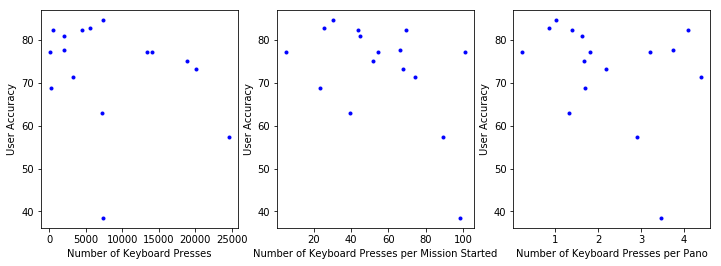

In [31]:
counting_graph('Number of Keyboard Presses', 'scatter_plot', 'LowLevelEvent_keydown')

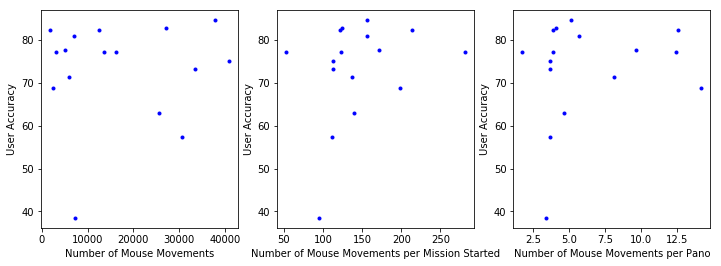

In [32]:
counting_graph('Number of Mouse Movements', 'scatter_plot', 'LowLevelEvent_mousedown')

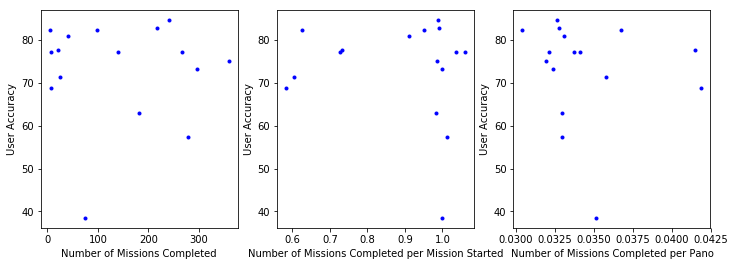

In [25]:
counting_graph('Number of Missions Completed', 'scatter_plot', 'MissionComplete')
# For two users, it shows that they have completed more missions than they have started.
# Unsure of the cause

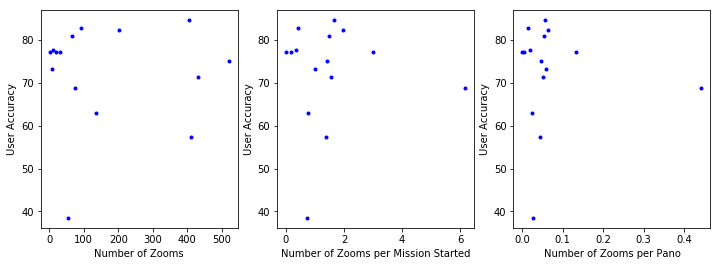

In [33]:
counting_graph('Number of Zooms', 'scatter_plot', 'Click_ZoomIn')

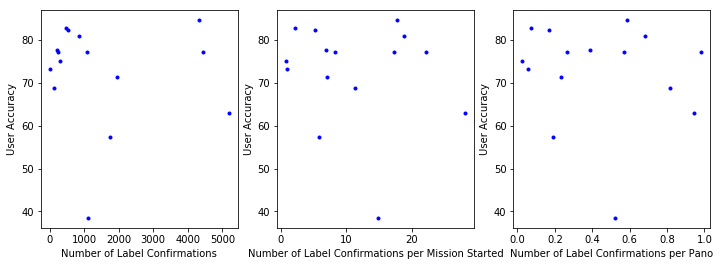

In [35]:
counting_graph('Number of Label Confirmations', 'scatter_plot', 'ContextMenu_OKButtonClick')

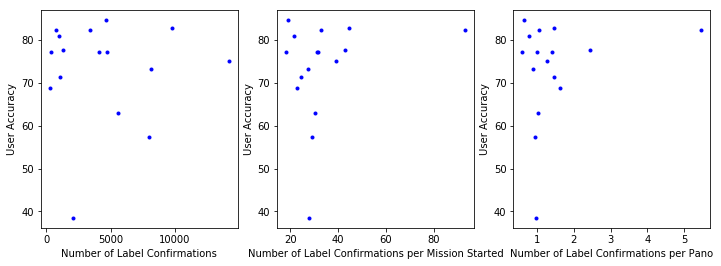

In [36]:
counting_graph('Number of Label Confirmations', 'scatter_plot', 'ContextMenu_Close')

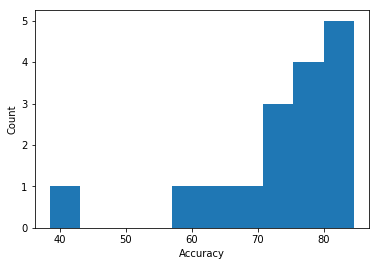

In [45]:
histogram('Accuracy', users[' accuracy'])